In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from conflab_gendata import Feeder_conflab, gendata_from_feeder

In [4]:
data_path = '../data/conflab_raw/coco'
label_path = '../data/conflab_raw/speaking_status'
max_frame = 300

In [5]:
feeder = Feeder_conflab(
        data_path=data_path,
        label_path=label_path,
        window_size=max_frame)

32it [01:51,  3.49s/it]
8it [00:01,  4.29it/s]


# occlusion stats

In [6]:
feeder.segments[0].keys()

dict_keys(['cam', 'vid', 'seg', 'tracks'])

In [7]:
# 0: frame num
# 1-35: skeleton
# 35-52: occlusion
feeder.segments[0]['tracks'][1][100]

array([100, 0.326890756302521, 0.3361302854992024, 0.3319327731092437,
       0.3017703007592839, None, None, 0.38907563025210085,
       0.3525633216791634, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, 0.4184873949579832, 0.40485025497903926,
       0.3865546218487395, 0.43921023971895773, 0, 1, None, 0, None, None,
       None, None, None, None, None, None, None, None, None, 0, 1],
      dtype=object)

In [8]:
occlusion_per_joint = np.zeros((17))
totals_per_joint = np.zeros((17), dtype=int)
for seg in feeder.segments:
    for pid, track in seg['tracks'].items():
        occlusion_data = track[:,-17:]

        has_occlusion = occlusion_data.copy()
        has_occlusion[has_occlusion != None] = 1
        has_occlusion[has_occlusion == None] = 0
        # print(np.sum(has_occlusion, axis=0))
        totals_per_joint = totals_per_joint + np.sum(has_occlusion, axis=0)


        has_positive_occlusion = occlusion_data.copy()
        has_positive_occlusion[has_positive_occlusion != 1] = 0
        occlusion_per_joint = occlusion_per_joint + np.sum(has_positive_occlusion, axis=0)

In [9]:
occlusion_per_joint

array([1062093.0, 1846553.0, 1943151.0, 1203790.0, 1525221.0, 1624206.0,
       1146377.0, 1520926.0, 1635187.0, 1825415.0, 2092482.0, 1916887.0,
       1780947.0, 1898989.0, 1928590.0, 1877012.0, 1846075.0],
      dtype=object)

In [10]:
totals_per_joint

array([3763390.0, 3628083.0, 3412835.0, 3747161.0, 3448178.0, 3476960.0,
       3450936.0, 3461919.0, 3505084.0, 3462530.0, 3441631.0, 3503150.0,
       3470407.0, 3456021.0, 3546396.0, 3828826.0, 3857605.0],
      dtype=object)

In [11]:
occlusion_per_joint / totals_per_joint

array([0.28221709681962276, 0.5089610684209815, 0.5693656446912904,
       0.3212538772686842, 0.4423266432301349, 0.467133933090976,
       0.332193062983492, 0.4393303251751413, 0.4665186340755314,
       0.5271911001493128, 0.6079913854797333, 0.5471895294235188,
       0.5131810188257458, 0.5494726449868216, 0.5438168777542045,
       0.4902317316065029, 0.4785546990943863], dtype=object)

# turn length & confidence stats

In [12]:
def apply_mpd(ss, mpd = 2):
    mpd_ss = ss.copy()
    pauses = []
    indices = np.where(np.diff(ss) != 0)[0]
    prev_index = 0
    for idx in indices:
        if ss[idx] == 0:
            pauses.append([prev_index, idx])
        prev_index = idx

    for pause in pauses:
        if pause[1] - pause[0] < mpd:
            mpd_ss[pause[0]+1:pause[1]+1] = 1
    return mpd_ss

In [13]:
test = np.array([1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1])
test

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [14]:
apply_mpd(test)

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
def get_frame_ss(ss):
    # zero out lines with no frame
    ss.loc[ss['index'] == 0, 'data0'] = np.nan
    ss = ss['data0'].to_numpy()

    last_status = 0
    for i in range(len(ss)):
        if np.isnan(ss[i]):
            ss[i] = last_status
        else:
            last_status = ss[i]
    return ss

In [16]:
def get_turns(ss):
    turns = []
    indices = np.where(np.diff(ss) != 0)[0]
    prev_index = 0
    for idx in indices:
        if ss[idx] == 1:
            turns.append([prev_index, idx])
        prev_index = idx
    return turns

In [17]:
def get_confidence(sig):
    sig = sig[sig['index'] != 0]
    conf = sig['data0'].to_numpy()
    return conf

In [18]:
test = np.array([1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1])
test

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [19]:
get_turns(test)

[[0, 1], [4, 7], [10, 13]]

In [20]:
occlusion_per_joint = np.zeros((17))
totals_per_joint = np.zeros((17), dtype=int)
turn_lengths = []
confidences = []
for seg, seg_data in feeder.labels.items():
    for pid, pid_data in seg_data.items():
        ss = get_frame_ss(pid_data['ss'])
        mpd_data = apply_mpd(ss)
        turns = get_turns(mpd_data)
        tl = [t[1] - t[0] for t in turns]
        turn_lengths = [*turn_lengths, *tl]
        if pid_data['conf'] is None:
            print(f'pid_data is None')
            continue
        confidences.append(get_confidence(pid_data['conf']))
turn_lengths = np.array(turn_lengths) / 60
confidences = np.concatenate(confidences)

pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None


In [21]:
import seaborn as sns
from matplotlib import pyplot as plt

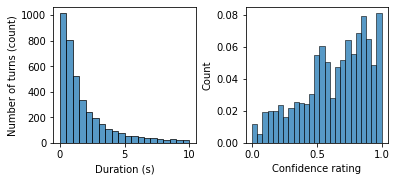

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
# ax1 = fig.add_subplot(121)
sns.histplot(data=turn_lengths, binrange=[0,10], binwidth=0.5, ax=ax1)
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel('Number of turns (count)')
# fig.savefig('turns.png', dpi=300, bbox_inches='tight')

# ax2 = fig.add_subplot(122)
sns.histplot(data=confidences, binrange=[0,1], binwidth=0.04, stat='probability', ax=ax2)
ax2.set_xlabel("Confidence rating")
ax2.set_ylabel('Count')
fig.subplots_adjust(wspace=0.35)
fig.savefig('ssstats.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Number of turns (count)')

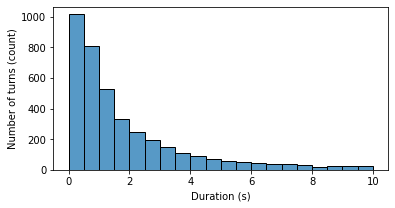

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))
sns.histplot(data=turn_lengths, binrange=[0,10], binwidth=0.5, ax=ax1)
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel('Number of turns (count)')

In [28]:
fig.savefig('ssstats.png', dpi=300, bbox_inches='tight')

In [202]:
feeder.labels['vid3_seg2'][40]['conf']

,Unnamed: 0,index,media_time,data0
0,0,0.0,0.0000,0.000000
1,1,0.0,0.0000,0.000000
2,2,0.0,0.0000,0.000000
3,3,4.0,0.0547,0.485347
4,4,0.0,0.0000,0.000000
...,...,...,...,...
7195,7195,0.0,0.0000,0.000000
7196,7196,0.0,0.0000,0.000000
7197,7197,0.0,0.0000,0.000000
7198,7198,0.0,0.0000,0.000000


In [29]:
len(turn_lengths)

4096